C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


            Loan_ID    Gender   Married  Dependents  Education  Self_Employed  \
Cluster                                                                         
0        302.828194  0.555066  0.096916    0.193833   0.215859       0.123348   
1        308.653747  0.971576  0.979328    1.067183   0.219638       0.139535   

         ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
Cluster                                                                     
0            4762.515419         992.101322  123.679724        351.198238   
1            5779.413437        1990.278863  159.746176        336.604651   

         Credit_History  Property_Area  Loan_Status  
Cluster                                              
0              0.835388       1.022026     0.638767  
1              0.846194       1.046512     0.715762  


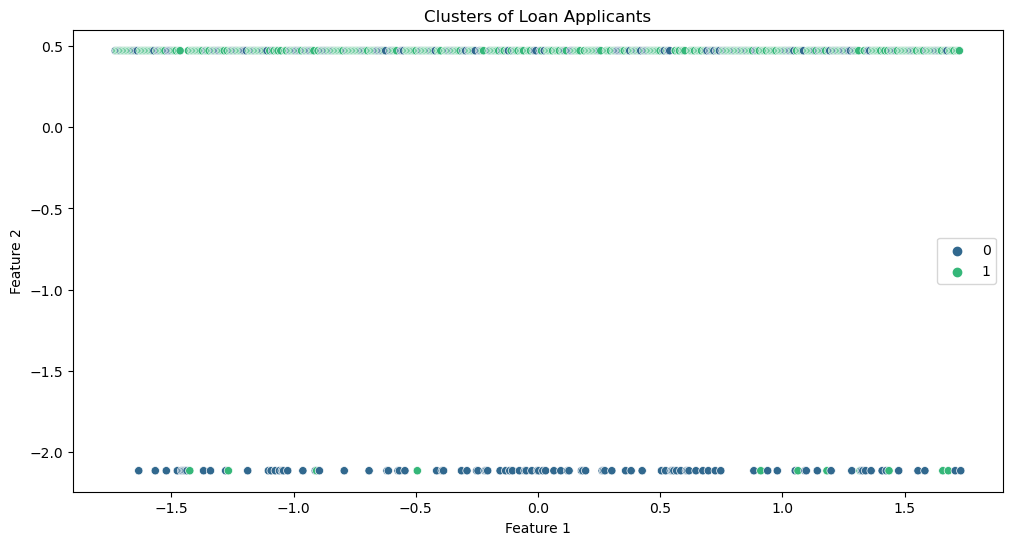

Loan_Status    0    1
Cluster              
0             82  145
1            110  277
Predicted Loan Status: 1


In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Training Dataset.csv')

# Preprocessing
# Fill missing values for numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Fill missing values for categorical columns
categorical_columns = df.select_dtypes(include=[object]).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

# Encode categorical variables
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Separate features and target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original data
df['Cluster'] = clusters

# Analyze the clusters
print(df.groupby('Cluster').mean())

# Plot the clusters (only using the first two features for visualization)
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=clusters, palette='viridis')
plt.title('Clusters of Loan Applicants')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Check the loan approval status distribution within clusters
cluster_approval = df.groupby(['Cluster', 'Loan_Status']).size().unstack().fillna(0)
print(cluster_approval)

# Use the clusters to predict loan approval
def predict_loan_status(new_data):
    # Preprocess the new data
    for column in new_data.select_dtypes(include=['object']).columns:
        if column in label_encoders:
            new_data[column] = label_encoders[column].transform(new_data[column])
    
    # Ensure new data has the same columns as training data
    missing_cols = set(X.columns) - set(new_data.columns)
    for col in missing_cols:
        new_data[col] = 0  # or any other default value
    
    # Reorder columns to match the training data
    new_data = new_data[X.columns]
    new_data = scaler.transform(new_data)
    
    # Predict clusters
    cluster = kmeans.predict(new_data)
    
    # Predict based on the majority class in the cluster
    # Retrieve the majority class for the predicted cluster
    predicted_status = [cluster_approval.loc[cl].idxmax() for cl in cluster]
    
    return predicted_status

# Example usage
new_data = pd.DataFrame({
    'Gender': ['Male'],
    'Married': ['Yes'],
    'Dependents': ['0'],
    'Education': ['Graduate'],
    'Self_Employed': ['No'],
    'ApplicantIncome': [5000],
    'CoapplicantIncome': [0],
    'LoanAmount': [200],
    'Loan_Amount_Term': [360],
    'Credit_History': [1],
    'Property_Area': ['Urban']
})

predicted_status = predict_loan_status(new_data)
print(f'Predicted Loan Status: {predicted_status[0]}')
